# Exploring the impact of data choices on a neural network

We have previously looked at how we can use non-NN and NN approaches to tackle a classification problem in the SDSS DR14 dataset. We have compared the two approaches and looked at how we could potentially look at optimising our NN.

The goal of this notebook is to look into two main questions:
1. - How does the amount of training data affect the performance of a neural network?
2. - How does the balance of classes in a classification problem affect the performance of a neural network?

We'll explore how varying the amount of training data can cause potential problems (such as overfitting) and it's impact on how well the model can generalise among the classes, as well as analysing the effect of class imbalance and how we can potentially adress the issues that arise from this.

# Libraries and reading the data

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
data = pd.read_csv('Skyserver_SQL2_27_2018 6_51_39 PM.csv')

# 1) Amount of training data
Generally, what we find is that if we increase the amount of training data available to the NN, the performance of the NN will increase. This will lead to higher accuracy and improved generalisation.

In addition to this, more data for the model to learn from will also prevent overfitting. Overfitting happens if there is insufficient data, essentially the model memorises the data, so when it comes to testing our model on unseen data it will perform poorly.

Before we begin to explore how this will impact our model, lets re-initialise our NN.

In [5]:
features = ['u', 'g', 'r', 'i', 'z']
X = data[features]
y = data['class']

#Encode the target variables
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.8, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

class StarGalaxyQuasarClassifier(nn.Module):
    def __init__(self):
        super(StarGalaxyQuasarClassifier, self).__init__()
        self.fc1 = nn.Linear(5, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 3)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = StarGalaxyQuasarClassifier()

In this block of code below, we will explore how the amount of training data available to the model affects it's performance. The aim here is to still give the model the standard 80:20 training and testing split, but we will then gradually reduce the fraction of the training data used to train the model.

For example, in the first loop we will train the model with 10% of the original 80% training data. We'll also look at a plot of accuracy and loss over the epochs against amount of training data.

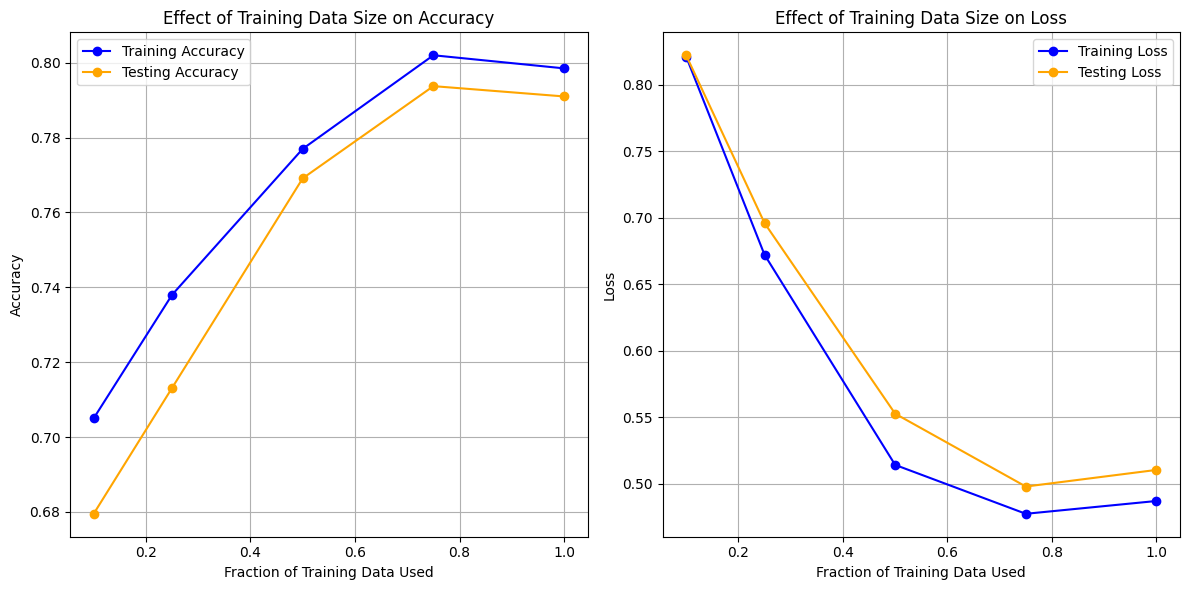

In [6]:
def evaluate_training_data_effect_with_cm(model, train_data, test_loader, fractions, criterion, optimizer, epochs=10):
    train_accuracies = []
    test_accuracies = []
    train_losses = []
    test_losses = []
    confusion_matrices = []  # To store confusion matrices

    for fraction in fractions:
        # Reduce training data size
        subset_size = int(len(train_data) * fraction)
        subset_data, _ = torch.utils.data.random_split(train_data, [subset_size, len(train_data) - subset_size])
        subset_loader = DataLoader(subset_data, batch_size=64, shuffle=True)

        # Reset model weights
        model.apply(lambda layer: layer.reset_parameters() if hasattr(layer, 'reset_parameters') else None)

        # Train model on reduced dataset
        model.train()
        for epoch in range(epochs):
            for inputs, labels in subset_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        # Evaluate on training data
        train_correct = 0
        train_total = 0
        running_train_loss = 0.0
        model.eval()
        with torch.no_grad():
            for inputs, labels in subset_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_train_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                train_correct += (predicted == labels).sum().item()
                train_total += labels.size(0)
        train_accuracies.append(train_correct / train_total)
        train_losses.append(running_train_loss / len(subset_loader))

        # Evaluate on test data
        test_correct = 0
        test_total = 0
        running_test_loss = 0.0
        all_labels = []
        all_preds = []
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                test_correct += (predicted == labels).sum().item()
                test_total += labels.size(0)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())

        test_accuracies.append(test_correct / test_total)
        test_losses.append(running_test_loss / len(test_loader))

        # Store the confusion matrix for later plotting
        cm = confusion_matrix(all_labels, all_preds)
        confusion_matrices.append((fraction, cm))

    # Plot accuracies
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(fractions, train_accuracies, marker='o', label='Training Accuracy', color='blue')
    plt.plot(fractions, test_accuracies, marker='o', label='Testing Accuracy', color='orange')
    plt.title("Effect of Training Data Size on Accuracy")
    plt.xlabel("Fraction of Training Data Used")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()

    # Plot losses
    plt.subplot(1, 2, 2)
    plt.plot(fractions, train_losses, marker='o', label='Training Loss', color='blue')
    plt.plot(fractions, test_losses, marker='o', label='Testing Loss', color='orange')
    plt.title("Effect of Training Data Size on Loss")
    plt.xlabel("Fraction of Training Data Used")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

    return confusion_matrices  # Return the confusion matrices
# Define fractions to test
fractions = [0.1, 0.25, 0.5, 0.75, 1.0]

# Re-instantiate model, criterion, and optimizer
model = StarGalaxyQuasarClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Call the function and store confusion matrices
confusion_matrices = evaluate_training_data_effect_with_cm(model, train_dataset, test_loader, fractions, criterion, optimizer, epochs=10)

Let's also take a look at some confusion matrices for each training fraction.

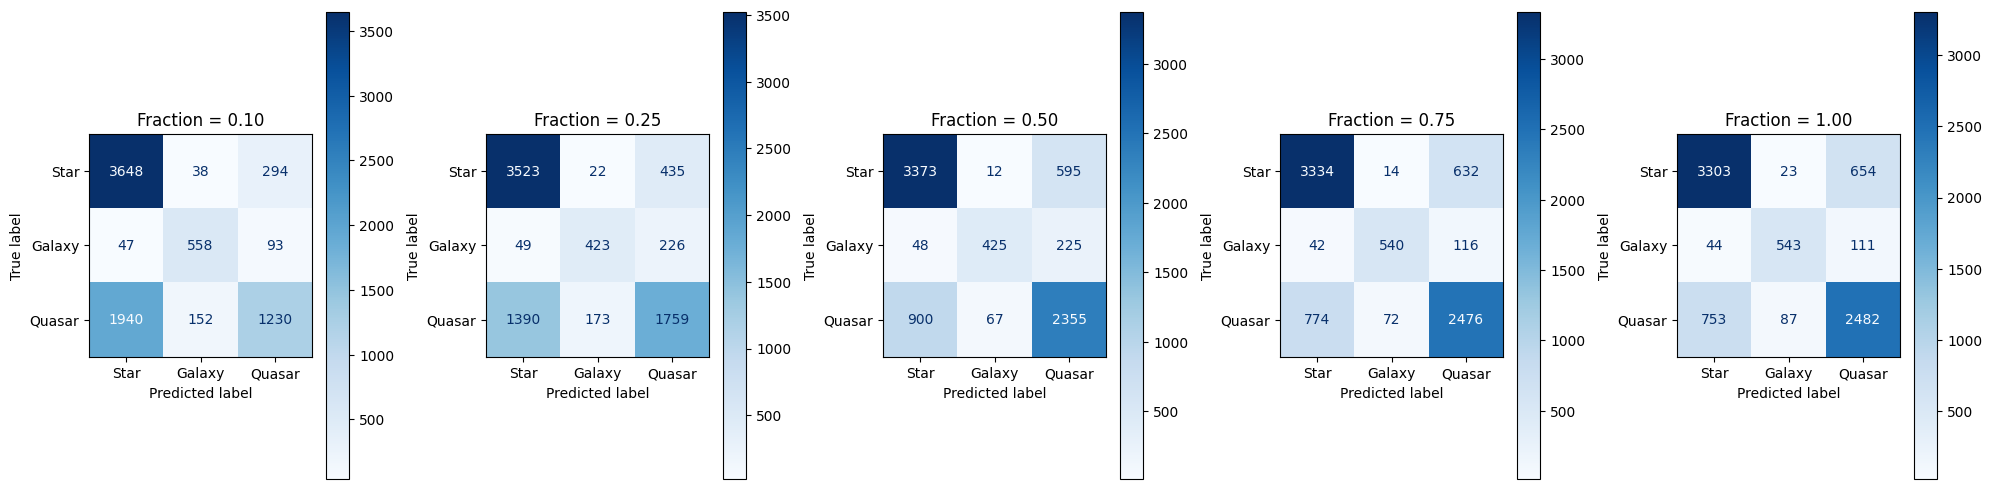

In [7]:
# Plotting confusion matrices in a loop
fig, axes = plt.subplots(1, len(confusion_matrices), figsize=(20, 5))

for ax, (fraction, cm) in zip(axes, confusion_matrices):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Star', 'Galaxy', 'Quasar'])
    disp.plot(cmap="Blues", values_format="d", ax=ax)
    ax.set_title(f"Fraction = {fraction:.2f}")

plt.tight_layout()
plt.show()


We can clearly see that the model performs significantly worse when there is less data available to train with (the expected result!), but what is interesting here is that the model's training performance remains relatively high even when there is less data available for it to train with. This is a strong example of **overfitting**.

As explained above, essentially the model is just memorising the training data, so it *seems* like the model is performing really well, but as we introduce the unseen data we can see that it's ability to generalise is quite poor - leading to overall worse accuracy compared to when the model has more data to train with.

This is even more obvious when we look at the confusion matrices. Especially at the lower fraction the model's ability to generalise is very poor. For example, if we look at the fraction of 0.1, the model is predicting everyting to be in the `STAR` class.

# 2) Balance of classes

Overall, the balance of classes in a classification problem can heavily affect how a NN performs. The most common way is that the model will begin to favour the more represented classes. Say if a dataset has two classes, A and B, and class A makes up 80% of that dataset, to reduce **overall** error the model will learn to predict class A the majority of the time as this will mean that it correct most of the time. Whilst this might lead to high accuracy overall, this means that there is a lower precision and recall for class B.

In the context of our model and dataset, lets explore the distribution of classes.

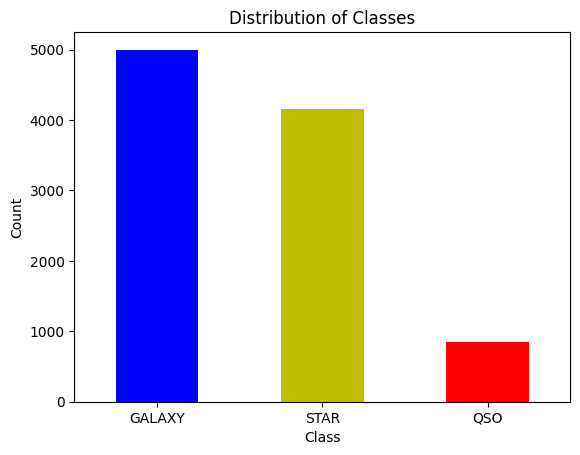

In [ ]:
data['class'].value_counts().plot(kind='bar', color=['b', 'y', 'r'])
plt.title("Distribution of Classes")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

As we can see, the `QSO` class is far less represented than the `GALAXY` and `STAR` classes. This could lead to potential problems with our model's performance as it could lead to the scenario described above, where it will rarely predict the `QSO` class as there are so few of them (~10% of the total data).

We'll explore how this class imbalance will affect our model.

Firstly, lets evaluate the performance of our model without any adjustments:

In [ ]:
# Selecting only the relevant features
features = ['u', 'g', 'r', 'i', 'z']
X = data[features]
y = data['class']

#Encode the target variables
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

class StarGalaxyQuasarClassifier(nn.Module):
    def __init__(self):
        super(StarGalaxyQuasarClassifier, self).__init__()
        self.fc1 = nn.Linear(5, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 3)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = StarGalaxyQuasarClassifier()

def train_model(model, train_loader, criterion, optimizer, epochs=20):
    model.train() # Set model into training mode
    loss_history = [] # Create an array to store average loss
    for epoch in range(epochs): # Iterate through the training process
        running_loss = 0.0
        for inputs, labels in train_loader: # loop through train_loader
            optimizer.zero_grad() # Clear gradients from previous epochs
            outputs = model(inputs) # Forward pass
            loss = criterion(outputs, labels) # Compute loss
            loss.backward()
            optimizer.step() # Adjusts moodel's weights based on previous back propagation
            running_loss += loss.item() # Accumulate the loss
        epoch_loss = running_loss / len(train_loader) # Loss for each epoch
        loss_history.append(epoch_loss) # Record the loss
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


loss_history = train_model(model, train_loader, criterion, optimizer, epochs=20)

def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # Calculate accuracy
    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}%")

    # Generate classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

# Evaluate the model
evaluate_model(model, test_loader)

Epoch 1/20, Loss: 0.7397
Epoch 2/20, Loss: 0.5476
Epoch 3/20, Loss: 0.4737
Epoch 4/20, Loss: 0.4056
Epoch 5/20, Loss: 0.3517
Epoch 6/20, Loss: 0.3103
Epoch 7/20, Loss: 0.2859
Epoch 8/20, Loss: 0.2739
Epoch 9/20, Loss: 0.2672
Epoch 10/20, Loss: 0.2532
Epoch 11/20, Loss: 0.2480
Epoch 12/20, Loss: 0.2422
Epoch 13/20, Loss: 0.2413
Epoch 14/20, Loss: 0.2334
Epoch 15/20, Loss: 0.2270
Epoch 16/20, Loss: 0.2230
Epoch 17/20, Loss: 0.2199
Epoch 18/20, Loss: 0.2212
Epoch 19/20, Loss: 0.2141
Epoch 20/20, Loss: 0.2172
Accuracy: 94.10%
Classification Report:
              precision    recall  f1-score   support

      GALAXY       0.96      0.93      0.95       996
         QSO       0.91      0.94      0.92       190
        STAR       0.92      0.95      0.94       814

    accuracy                           0.94      2000
   macro avg       0.93      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000



We can clearly see that due to the fact that the `QSO` class is under-represented, its score in the precision, recall and f1-score suffer compared to the other two classes.

There are ways that we could potentially compensate for this class imbalance. One particular method is to under-sample the classes that have the biggest representation.

In this case we will under-sample the `STAR` and `GALAXY` class in the hope that it will bring the precision, recall and f-1 score of the `QSO` class more in-line with the other classes.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report
import numpy as np

# Selecting only the relevant features
features = ['u', 'g', 'r', 'i', 'z']
X = data[features]
y = data['class']

# Encode the target variables
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Find the indices for each class
star_indices = np.where(y_train == 0)[0]    # class '0' is for stars
galaxy_indices = np.where(y_train == 1)[0]  # class '1' is for galaxies
quasar_indices = np.where(y_train == 2)[0]  # class '2' is for quasars

# Get the number of samples in the minority class (quasars)
num_quasars = len(quasar_indices)

# Check the number of samples in the majority classes
num_stars = len(star_indices)
num_galaxies = len(galaxy_indices)

# Make sure we don't try to sample more than what's available
num_stars_to_sample = min(num_stars, num_quasars)  # Take min to avoid the error
num_galaxies_to_sample = min(num_galaxies, num_quasars)  # Take min to avoid the error

# Undersample stars and galaxies)
star_indices_undersampled = np.random.choice(star_indices, size=num_stars_to_sample, replace=False)
galaxy_indices_undersampled = np.random.choice(galaxy_indices, size=num_galaxies_to_sample, replace=False)

# Combine the indices
undersampled_indices = np.concatenate([star_indices_undersampled, galaxy_indices_undersampled, quasar_indices])

# Create the balanced training dataset
X_train_balanced = X_train[undersampled_indices]
y_train_balanced = y_train[undersampled_indices]

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_balanced, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_balanced, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the model
class StarGalaxyQuasarClassifier(nn.Module):
    def __init__(self):
        super(StarGalaxyQuasarClassifier, self).__init__()
        self.fc1 = nn.Linear(5, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 3)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = StarGalaxyQuasarClassifier()

# Training function
def train_model(model, train_loader, criterion, optimizer, epochs=20):
    model.train()  # Set model into training mode
    loss_history = []  # Create an array to store average loss
    for epoch in range(epochs):  # Iterate through the training process
        running_loss = 0.0
        for inputs, labels in train_loader:  # Loop through train_loader
            optimizer.zero_grad()  # Clear gradients from previous epochs
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()
            optimizer.step()  # Adjust model's weights based on previous backpropagation
            running_loss += loss.item()  # Accumulate the loss
        epoch_loss = running_loss / len(train_loader)  # Loss for each epoch
        loss_history.append(epoch_loss)  # Record the loss
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")
    return loss_history

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
loss_history = train_model(model, train_loader, criterion, optimizer, epochs=20)

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # Calculate accuracy
    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}%")

    # Generate classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

# Evaluate the model
evaluate_model(model, test_loader)


Epoch 1/20, Loss: 0.8410
Epoch 2/20, Loss: 0.5887
Epoch 3/20, Loss: 0.4989
Epoch 4/20, Loss: 0.4266
Epoch 5/20, Loss: 0.3823
Epoch 6/20, Loss: 0.3384
Epoch 7/20, Loss: 0.3144
Epoch 8/20, Loss: 0.2959
Epoch 9/20, Loss: 0.2887
Epoch 10/20, Loss: 0.2844
Epoch 11/20, Loss: 0.2743
Epoch 12/20, Loss: 0.2725
Epoch 13/20, Loss: 0.2606
Epoch 14/20, Loss: 0.2577
Epoch 15/20, Loss: 0.2492
Epoch 16/20, Loss: 0.2497
Epoch 17/20, Loss: 0.2418
Epoch 18/20, Loss: 0.2386
Epoch 19/20, Loss: 0.2379
Epoch 20/20, Loss: 0.2314
Accuracy: 93.50%
Classification Report:
              precision    recall  f1-score   support

      GALAXY       0.97      0.91      0.94       996
         QSO       0.92      0.92      0.92       190
        STAR       0.90      0.96      0.93       814

    accuracy                           0.94      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.94      0.94      0.94      2000



Under-sampling the `STAR` and `GALAXY` class has brought the scores of `QSO` class closer to the scores of the majority classes, especially in the f-1 score which is particularly important as this is the average of precision and recall of that class. F-1 score is also a particularly important metric when using a dataset that is imbalanced much like our one is.

Other methods that could improve the `QSO` class' performance include:
- Oversampling `QSO` using synthetic data generation techniques like SMOTE (Synthetic Minority Over-sampling Technique) or by duplicating examples
- Adjusting the weight of the classes

# Conclusion

In this notebook we have explored how 2 key factors affect the performance of a NN:
- The amount of training data available to the model
- How class imabance in a classification probelm affects performance

We found that when there is insufficient training data available, the model will overfit and give the illusion that it is performing well when we look at the training accuracy, but when we look at the overall accuracy it becomes clear that the model's overall performance is poor.

Furthermore, we also tackled the issue of class imbalance within our dataset, in particular how the `QSO` class is by far the minority class. Our model often developed a bias towards `STAR` and `GALAXY`, but we employed strategies that ensured a more balanced representation of all classes by under-sampling the majority classes (`STAR` and `GALAXY`).

These experiements show what we must take into consideration when developing a NN or any machine learning model, and how we can enhance the performance of the model by taking these factors into account.